<h2> Load Data</h2>

In [38]:
import warnings
import matplotlib.pyplot as plt
import json
import numpy as np
import preparers
import sonaion_analysis as son
import GenSnippetsLib as snippet
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [39]:
data = preparers.load_queried(
    participant_number=1,
    snippets=["BogoSort"],
    query_code=True,
    query_eye_tracking=True,
)

Loading BogoSort Files .....

<h2>potential funtion arguments</h2>

In [40]:
def get_line_bounds(img, image_path):
    height = img.size[1]
    with open(image_path) as json_file:
        data = json.load(json_file)
        height_margin = data["height-margin"]
        loc = len(data["source-code"])
        height = height - 2 * height_margin

    step_size = height/loc
    bounds = []
    for i in range(loc):
        lower = int(i*step_size) + height_margin
        higher = int((i+1)*step_size) + height_margin
        bounds.append((i, lower, higher))

    return bounds

In [41]:
fig, ax = (None, None)
denoise_degree = 10
display_width = 1920
display_height = 1080
left_color = (0.0, 1.0, 1.0)
right_color = (0.0, 1.0, 0.0)
image_path = "../CodeSnippets/Generators/" + "BogoSort" + ".json"
img, result = snippet.create_image(image_path, font_path="/../CodeSnippets/fonts/ttf/")
offset = int(display_height*0.5-img.size[1]*0.5)
img_bounds = get_line_bounds(img, image_path)
img_bounds = [(i, low + offset, high + offset) for i, low, high in img_bounds]
loc = len(img_bounds)
line_middle = [int((low+height)/2) for i, low, height in img_bounds]
bg = snippet.create_background(display_width, display_height, (180, 180, 180, 255))
img = snippet.place_image_on(bg, np.array(img), 0.5, 0.5)
cat = np.full(display_height, None)
for i, low, height in img_bounds:
    for j in range(low, height):
        cat[j] = i

<h2> Prepare queried Data</h2>

In [42]:
df_eyetracking = data["BogoSort"]["Code"]["EyeTracking"][
    [
        "l_valid",
        "l_display_x",
        "l_display_y",
        "time",
        "l_pupil_diameter",
    ]
]
df_eyetracking["l_display_x"] = df_eyetracking["l_display_x"].apply(lambda x: x * display_width)
df_eyetracking["l_display_x"] = df_eyetracking["l_display_x"].astype(int)

df_eyetracking["l_display_y"] = df_eyetracking["l_display_y"].apply(lambda x: x * display_height)
df_eyetracking["l_display_y"] = df_eyetracking["l_display_y"].astype(int)

df_eyetracking["time"] = df_eyetracking["time"] - df_eyetracking["time"][0]

In [43]:
(
    replaced_l_x,
    replaced_l_y,
    replaced_l_diameter,
    replaced_l_valid,
) = son.eyetracking.preprocessing_invalid.replace_with_prev_invalid(
    df_eyetracking["l_display_x"],
    df_eyetracking["l_display_y"],
    df_eyetracking["l_pupil_diameter"],
    df_eyetracking["l_valid"],
)

df_eyetracking["l_display_x"] = replaced_l_x
df_eyetracking["l_display_y"] = replaced_l_y
df_eyetracking["l_pupil_diameter"] = replaced_l_diameter
df_eyetracking["l_valid"] = replaced_l_valid

In [44]:
for _i in range(denoise_degree):
    denoised_l_x, denoised_l_y = son.eyetracking.preprocessing_denoise.denoise(
        df_eyetracking["l_display_x"],
        df_eyetracking["l_display_y"],
        son.eyetracking.preprocessing_denoise.parabola_5_kernel,
    )

    df_eyetracking["l_display_x"] = denoised_l_x
    df_eyetracking["l_display_y"] = denoised_l_y

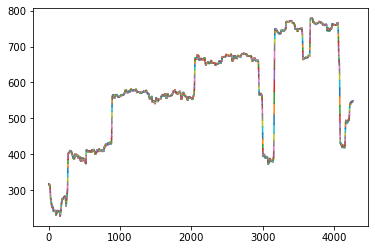

In [45]:
prev = df_eyetracking["l_display_y"][0]
for idx, y in enumerate(df_eyetracking["l_display_y"]):
    plt.plot([idx-1, idx], [prev, y])
    prev = y

In [46]:
df_eyetracking["l_display_y"] =  df_eyetracking["l_display_y"].apply(lambda x: line_middle[cat[x]] if cat[x] is not None else float("Nan"))
df_eyetracking = df_eyetracking[df_eyetracking["l_display_y"].notnull()]
df_eyetracking["l_display_y"] = df_eyetracking["l_display_y"].astype(int)
df_eyetracking = df_eyetracking.reset_index()

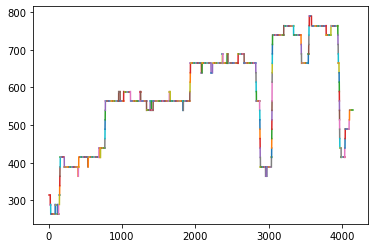

In [47]:
prev = df_eyetracking["l_display_y"][0]
for idx, y in enumerate(df_eyetracking["l_display_y"]):
    plt.plot([idx-1, idx], [prev, y])
    prev = y

<h2> Make Heatmaps</h2>

In [48]:
def mask_function():
    return lambda height, width, coordinate: son.utils.masks.create_circular_mask(height, width, coordinate, 30)

data_left = son.eyetracking.heatmap.create_heatmap(
    df_eyetracking["l_display_x"],
    df_eyetracking["l_display_y"],
    df_eyetracking["l_valid"],
    0.004,
    display_width,
    display_height,
    mask_function(),
)

data_left = data_left / data_left.max()
data_left = np.array([data_left * left_color[0], data_left * left_color[1], data_left * left_color[2], data_left])
data_left = np.moveaxis(data_left, 0, 2)

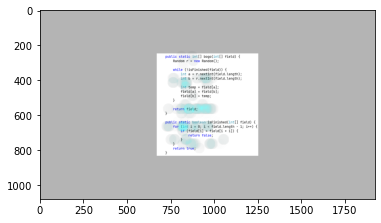

In [49]:
fig, ax = plt.subplots()
ax.imshow(data_left, zorder=2, alpha=0.5)
ax.imshow(img, zorder=1)
plt.show()

<h2>Make Sequence Diagrams</h2>

In [50]:
max_pixel = 500
step_size = max_pixel/len(df_eyetracking)

In [51]:
data_left = son.eyetracking.sequence.create_sequence_diagram_y(
    df_eyetracking["l_display_y"],
    df_eyetracking["l_valid"],
    display_height,
    display_width,
    offset=0,
    step=step_size,
    should_skip=False,
)
data_left = np.array([data_left * left_color[0], data_left * left_color[1], data_left * left_color[2], data_left])
data_left = np.moveaxis(data_left, 0, 2)

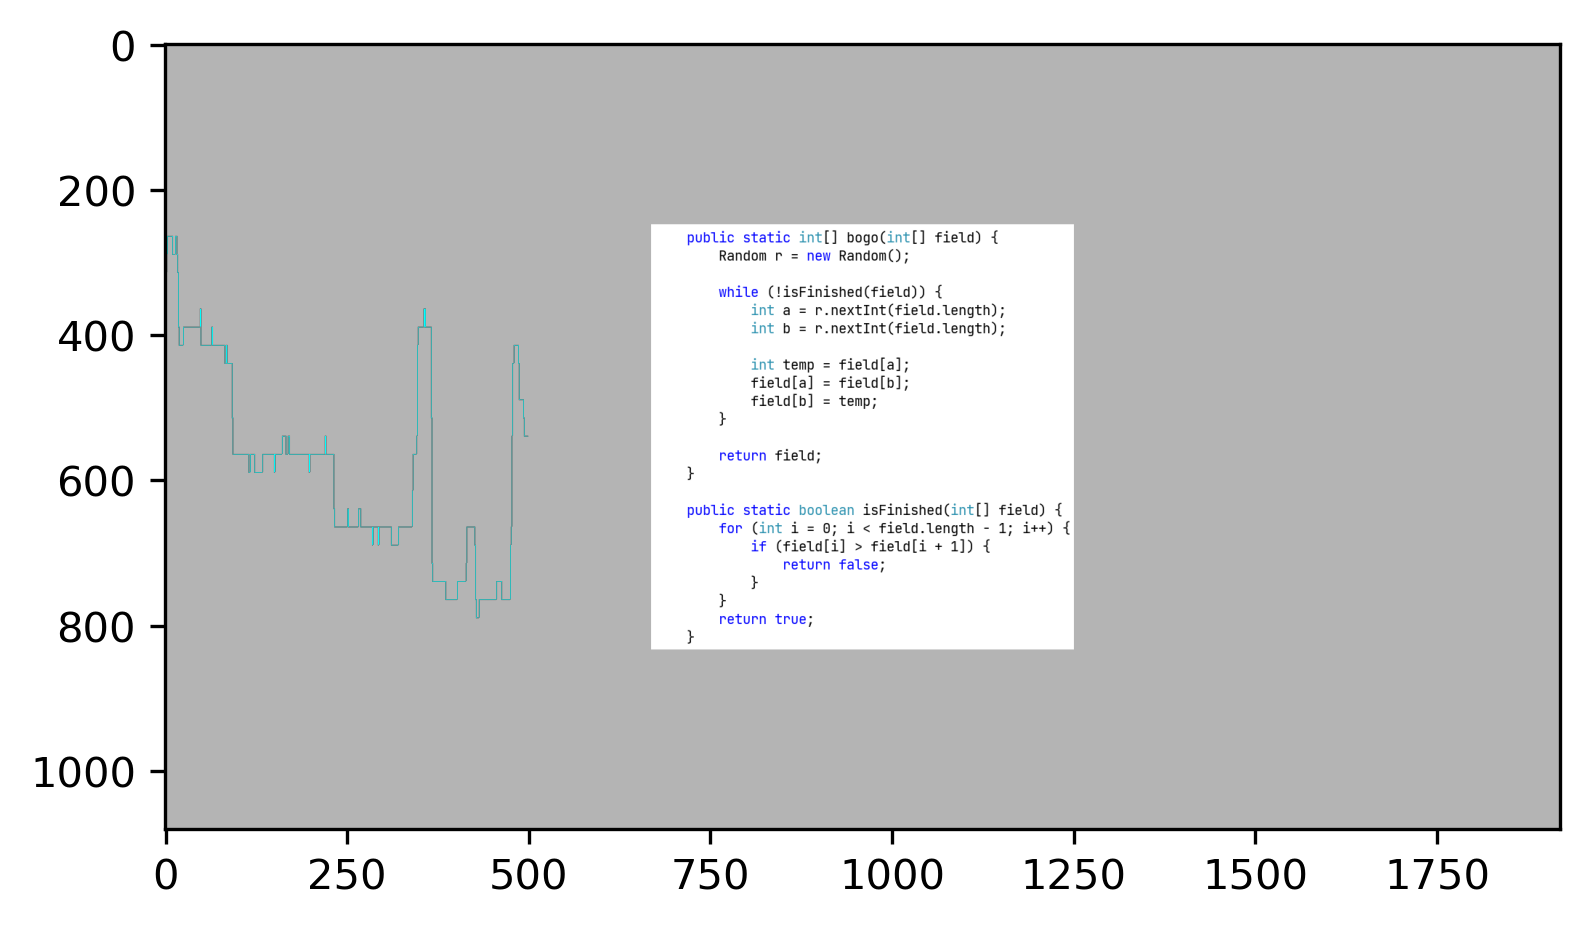

In [58]:
fig, ax = plt.subplots(dpi=300)
ax.imshow(data_left, zorder=2)
ax.imshow(img, zorder=1)
plt.show()

<h2>Fixxations and Saccades</h2>

In [59]:
data = df_eyetracking["l_display_y"].apply(lambda x: cat[x])

columns = {}
for i in range(-1*loc, loc+1):
    columns[i] = 0

movement = []
prev_line = data[0]
for idx, current_line in enumerate(data):
    if idx == 0:
        prev_line = current_line
        continue
    movement.append(current_line-prev_line)
    prev_line = current_line

In [60]:
movement

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
